# Tarea 3: Redes Neuronales

ME4707 - Robótica - Semestre 2020-2

Profesor: Juan C. Zagal - Ayudante Laboratorio: Gaspar Fábrega

# 1. Introducción

Entre los algoritmos más comunes dentro del Machine Learning (ML) se encuentran las Redes Neuronales o Neural Networks (NN) que son algoritmos bioinspirados en la forma en que nuestro cerebros procesan información mediante transmisión de señales eléctricas entre las neuronas. Al igual que la mente de un bebé va aprendiendo al ir experimentando y creciendo, las redes neuronales aprenden del error. En el caso del Aprendizaje Supervisado es posible utilizar conjuntos de entrenamiento donde existen pares de datos de entrada y salida `(X, Y)`, ya conocidos, para que la red aprenda de estos a extraer las características y patrones necesarios para llevar a cabo la tarea deseada, ya sea de clasificación o regresión. 

De este modo, inicialmente las redes comienzan por predecir resultados totalmente erróneos a partir de los datos entregados. No obstante, a medida que esta va siendo entrenada, va ajustando sus parámetros internos para corregir sus respuestas y acercarse los más posible a los resultados esperados.

Las Neural Networks se estructuran en una red de nodos generalmente ordenados por capas, que mediante una serie de ponderaciones y conexiones convierten una serie de inputs X en outputs Y. Dependiendo de como se estructuren las redes neuronales, estas pueden cumplir diferentes funciones, permitiéndoles ser aplicadas en una gran variedad de problemas, desde prevensión de fraudes bancarios hasta detección de tumores mediante radiografías.

En esta tarea los problemas se abordarán desde un punto de vista más analítico, acercando a las y los estudiantes al funcionamiento y programación de redes neuronales al observar el desempeño de estas en problemas de distinta índole.

# 2. Formato de entrega
La tarea se desarrollará en [Google Colab](https://colab.research.google.com/) en un entorno de Python 3. Debe trabajar sobre este mismo archivo .ipynb completando lo que se requiere en cada problema. Se debe entregar:
- Reporte de resultados (en un archivo .pdf) y análisis de estos de acuerdo con las distintas partes de la tarea.
- En el archivo .ipynb deben dejar la mejor red que hayan logrado.

# 3. Problema Clasificación ANN

Se comenzará por analizar un problema de clasificación bastante simple inspirado en el Neural Network Playground de TensorFlow (https://playground.tensorflow.org). En este caso, los puntos son segmentados o bien, etiquetados, en dos regiones dentro de los cuadrantes que se muestran en el diagrama a continuación. Así, el objetivo de nuestro modelo será clasificar la etiqueta de los puntos dentro de este espacio apartir del par de puntos $(x1, x2)$ como valores de entrada.

<img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/tarea_03/bin/problema_01_ref.png" height="280">


## 3.1 Dataset
En este problema se dispone de una serie de puntos (dataset) en el espacio cartesiano $(x_1, x_2)$, los cuales son clasificados en base a su posición en el espacio. Lea con atención el código a continuación que permite la generación de este dataset `(X, Y)`.

In [ ]:
# generación dataset------

# importar librerías
import random
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

# cantidad de datos en el dataset
data_size = 5000

# proporción de ruido en el dataset
data_noise = 0.0

# inicializar sets de datos
# X contiene los puntos cartesianos (x, y)
# Y contiene las etiquetas de clasificación de cada punto
# donde 1 significa que se encuentra dentro del radio y 0 que no.
X = np.zeros( (data_size, 2) )
Y = np.zeros( (data_size, 2) )

# generar datos al azar
for i in np.arange(data_size):
  x1 = 2*random.random() - 1
  x2 = 2*random.random() - 1

  # agregar al set X de puntos
  X[i, 0] = x1
  X[i, 1] = x2

  # agregar etiqueta al set Y
  if cos(x1*3*pi)*cos(x2*3*pi) > 0.0:
    Y[i, 0] = 0
    Y[i, 1] = 1
  else:
    Y[i, 0] = 1
    Y[i, 1] = 0

  # agregar ruido al dato (utilizado más adelante)
  if random.random() < data_noise:
    Y[i, :] = 1 - Y[i, :]

# plotear distribución en el dataset
plt.figure( figsize=(7,7) )
plt.scatter(X[:,0], X[:,1], c=Y[:,0], cmap='plasma', alpha=0.5, s=50)

## 3.2 Data Splitting

Teniendo ya el dataset para el entrenamiento de la NN, se debe dividir este en dos sets: uno de entrenamiento (`training set`) y otro de testing (`testing set`). El primero es utilizado, como su nombre lo indica, en el entrenamiento de la red neuronal; mientras que el segundo es utilizado para evaluar el _accuracy_ de la red ya entrenada.

Como la red es evaluada con datos que "nunca ha visto" durante el entrenamiento, este resultado permite observar si la red ha logrado generalizar el problema o si se ha _overfitteado_ (aprenderse los datos de entrenamiento de "memoria").

El _data splitting_ se puede lograr con el siguiente código:

In [ ]:
# importar librerías
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# generar sets de datos de training y testing
# la varibale test_size permite controlar la proporción entre los datos de testing y training.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## 3.3 Model Setup

Con los sets de entrenamiento y testing listos se puede dar paso a la configuración y entrenamiento de la red neuronal. Para esto se utilizará la librería `keras` o `tf.keras` de `TensorFlow`. Keras es una API de alto nivel para la creación y el entrenamiento de modelos de deep learning. Está orientada y diseñada para la construcción de modelos de forma modular o en bloques. De este modo, ofrece un framework mucho más amigable e intuitivo para principiantes, a la vez que mantiene un estructura personalizable y versátil que permite a usuarios más avanzados incorporar nuevas ideas.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_02/bin/keras_logo.png" width="400">

Los elemenos básicos para la construcción de un modelo o `keras.Model` consisten en las capas o `layers` del modelo. En este sentido, configurar un modelo en Keras resulta en ir uniendo o conectando capas `keras.layers` de manera secuencial.

Para comenzar e introducir el framework de esta librería, construiremos un modelo o red neuronal `Sequential` a partir de únicamente capas `keras.layers.Dense` y otras capas elementales.
- https://keras.io/api/layers/
- https://keras.io/api/layers/activations/

En términos generales, compondremos nuestro modelo de una serie de capas `Dense`, que se encargarán de procesar la información y los patrones de los datos de entrada hasta una última capa `Dense` con únicamente dos nodos que determinarán las etiquetas de los puntos $(x_1, x_2)$ que se ingresen al modelo.
A continuación se presenta el código necesario para configurar una red de este tipo.


In [ ]:
# importar librerías
import keras 
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.utils import plot_model

# inicializar modelo keras.Sequential
model = Sequential()

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
input_dim = ( 2, )
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Dense.
# https://keras.io/api/layers/core_layers/dense/

# las keras.layers.Dense reciben la cantidad de nodos o units dentro
# de la capa y la función de activación que operarán.
# https://keras.io/api/layers/activations/
model.add(Dense(units = 12, activation = 'relu'))
model.add(Dense(units = 12, activation = 'relu'))

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas o estados de salud.
labels_num = 2
model.add(Dense(units = labels_num, activation = 'softmax'))

# imprimir resumen del modelo
model.summary()

Parte de este analisis consiste en experimentar con distintas cantidades de capas, nodos e incluso funciones de activación (https://keras.io/activations/). Sientase en libertad de modificar la arquitectura de esta red según le parezca.

Para entrenar esta red o bien llamado, modelo, basta compilarlo y entreneralo con los sets de datos generados anteriormente. En este caso utilizaremos los datos de `testing` como datos de validación para monitorear directamente el desempeño del modelo sobre el conjunto de evaluación.

In [ ]:
# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy, 'categorical_crossentropy'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ---
# realizar rutina de entrenamiento
train_history = model.fit(X_train, Y_train,
                          batch_size=128, epochs=200,
                          validation_data=(X_test, Y_test) )

## 3.3 Model Evaluation

Para evaluar el desempeño de este modelo de clasificación existen múltiples herramientas:
-  Gráfico de función de pérdida: La función de pérdida o _loss function_ es el paramétro que se va optimizando a medida que la red se entrena. La red neuronal va ajustando los pesos de ponderación entre los nodos tal de minimizar este paramétro. En el gráfico de función de perdida se puede visualizar el desempeño del entrenamiento del modelo y además la convergencia entre la curva de `training` y `validation`. Si la curva de `validation` se escapa considerablemente de la curva de `training` esto es un indicador de que el modelo ha sufrido _overfitting_ y por tanto ha perdido generalidad (se aprende los datos de `training` de memoria).

- Matriz de confusión: Esta tabla permite comparar las predicciones del modelo versus las etiquetas reales de los datos.

- Heat Map o Mapa de Clasificación: En el caso de modelos que operan sobre datos 2D, o en el espacio cartesiano, es posible visualizar el resultado de la red neuronal dentro de todo el dominio de los datos (espacio cartesiano). Así es posible visualizar de forma más directa el criterio de clasificación del modelo.

Dentro del github del curso `roboticafcfm` se encuentran implementadas las funciones `plot_loss_function`, `plot_confusion_matrix` y `plot_classification_map` para facilitar el uso de estas herramientas. Para cargarlas dentro del entorno de Colab debe ejecutar el siguiente bloque de código.

In [ ]:
!git clone https://github.com/cherrerab/roboticafcfm.git
%cd /content/roboticafcfm

Una vez importado el github del curso, ejecute el siguiente bloque de código y observe los resultados del modelo.

In [ ]:
from utils import plot_loss_function
from utils import plot_confusion_matrix
from utils import plot_classification_map

# obtener predicciones de X_test con model.predict
Y_pred = 

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding
# utilizando np.argmax
Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)

# plot gráfico de función de pérdida
plot_loss_function(model)

# matriz de confusión
plot_confusion_matrix(Y_true, Y_pred,
                      target_names=['Azul', 'Amarillo'], figsize=(6, 6))

# classification map
plot_classification_map(model, (0,1), (0,1), 256)

## 3.4 Preguntas

- Registre los resultados de esta primera red neuronal "simple" en su reporte. Luego, agregue más capas a la red y aumente la cantidad de nodos de estas. También pruebe utilizando distintas funciones de activación. Mejore la red lo más posible procurando maximizar el parámetro _val_acc_ mostrado durante el entrenamiento (mientras más cercano a 1.0 mejor). Registre los resultados de esta red mejorada y comente sobre la razón de este mejor desempeño.
- En la sección en que se genera el dataset existe el parámetro _data_noise_, este define el porcentaje de ruido a agregar al dataset. Elija tres valores entre [0.05, 0.5] y entrene su red mejorada con estos tres nuevos sets con ruido. Registre los resultados y comente sobre los cambios en el desempeño (utilice los gráficos).

# 4. Problema Clasificación CNN
 
A partir del problema anterior, es claro que las redes neuronales son capaces de resolver problemas de clasificación simples, incluso ante la presencia de algo de ruido. La pregunta entonces radica si son capaces de resolver problemas de clasificación más complejos, como por ejemplo, clasificación de imágenes digitales.

En este problema se trabajará con un dataset que contiene cerca de 60.000 imágenes de `32x32px` correspondientes a 10 clases distintas (perros, ranas, barcos, camiones, etc.) llamado CIFAR-10. El objetivo de este problema es desarrollar una Red Neuronal Convolucional o Convolutional Neural Network (CNN) capaz de discernir entre las distintas clases y lograr clasificar correctamente cada imagen de acuerdo a su clase correspondiente.

Mas información sobre el dataset: https://www.cs.toronto.edu/~kriz/cifar.html

<img src="https://miro.medium.com/max/944/1*6XQqOifwnmplS22zCRRVaw.png" height="250"> <img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/tarea_03/bin/problema_02_ref.png" height="250">


## 4.1 Dataset

El dataset CIFAR-10 puede ser obtenido corriendo el código a continuación.

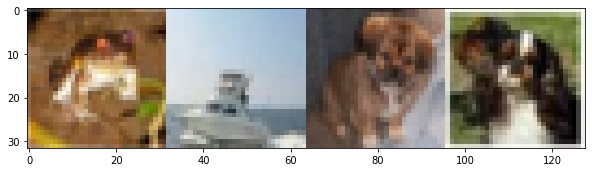

In [13]:
# importar librerías
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt 

# importar sets de training y testing
(X_train, Y_train_non_one_hot), (X_test, Y_test_non_one_hot) = cifar10.load_data()

# ---
# visualizar algunas imágenes dentro del dataset
imgs = np.hstack( [X_train[0,:,:], X_train[100,:,:],
                   X_train[217,:,:], X_train[500,:,:]] )

plt.figure( figsize=(10,10) )
plt.imshow(imgs)


Como se puede observar, el dataset ya se encuentra separado en sets de training y testing. No obstante, es necesario algo de procesamiento previo al entrenamiento. Corra el bloque de código a continuación para preparar los datos.

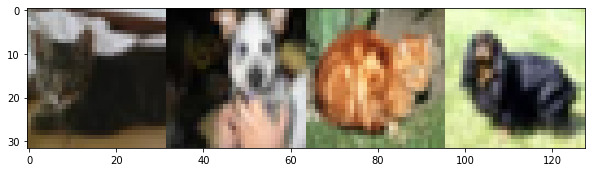

In [16]:
# importar librerías
from keras.utils import to_categorical
import numpy as np

# ---
# dado que las etiquetas no vienen con one-hot encoding las transformamos a estas.
# one-hot-encoding consiste en codificar las etiquetas de la forma [0, 0, 1]
# cuando, por ejemplo, se tienen tres clases. Así, esta estructura es compatible
# con la salida de una capa softmax.

# para esto se puede utilizar la función to_categorical de keras.utils
Y_train = to_categorical(Y_train_non_one_hot, 10)
Y_test = to_categorical(Y_test_non_one_hot, 10)

# ---
# para un experimento posterior aislaremos las clases correspondientes
# a las clases de perros y gatos, donde la etiqueta 5 corresponde a perros
# y la etiqueta 3 a gatos.
X_dc_train = np.zeros( (10000, 32, 32, 3) )
Y_dc_train = np.zeros( (10000, 1) )

X_dc_test = np.zeros( (2000, 32, 32, 3) )
Y_dc_test = np.zeros( (2000, 1) )


n = 0
# recorreremos todas la imágenes en cifar-10
for i in range(X_train.shape[0]):
  # si tiene la etiqueta correspondiente a perro
  if (Y_train_non_one_hot[i][0] == 5):
    # agregamos la imágen al dataset
    X_dc_train[n,:,:,:] = X_train[i,:,:,:]
    Y_dc_train[n] = 0
    n = n+1

  # si tiene la etiqueta correspondiente a gato
  elif (Y_train_non_one_hot[i][0] == 3):
    X_dc_train[n,:,:,:] = X_train[i,:,:,:]
    Y_dc_train[n] = 1
    n = n+1

# datos testing
n = 0
for i in range(X_test.shape[0]):
  # si tiene la etiqueta correspondiente a perro
  if (Y_test_non_one_hot[i][0] == 5):
    X_dc_test[n,:,:,:] = X_test[i,:,:,:]
    Y_dc_test[n] = 0
    n = n+1
  # si tiene la etiqueta correspondiente a gato
  elif (Y_test_non_one_hot[i][0] == 3):
    X_dc_test[n,:,:,:] = X_test[i,:,:,:]
    Y_dc_test[n] = 1
    n = n+1

# pasamos a one hot encoding
Y_dc_train = to_categorical(Y_dc_train, 2)
Y_dc_test = to_categorical(Y_dc_test, 2)

# ---
# mostrar ejemplos
imgs = np.hstack( [X_dc_train[0,:,:], X_dc_train[100,:,:],
                   X_dc_train[200,:,:], X_dc_train[300,:,:]] )

plt.figure( figsize=(10,10) )
plt.imshow(np.uint8(imgs))


## 4.2 Model Setup
En el desarrollo de una red CNN hay tres nuevos tipos de capas a tomar en consideración.
- Conv2D (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Esta capa en vez de componerse de nodos se compone de filtros (como los vistos en el capítulo de visión computacional), cada uno de estos filtros es convolucionado con la imagen de entrada produciendo una nueva imagen _filtrada_ que pasa a la siguiente capa.
- MaxPooling2D (https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): A medida que avanza la información a través de la red, conviene ir reduciendo el tamaño de las imágenes tal de ir aislando únicamente la información relevante (_features_). Además, así se reduce significativamente el costo computacional durante el entrenamiento. Este tipo de capas reduce las dimensiones de las imágenes que entran a estas.

- Flatten (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): Dado que después de todo este es un problema de clasificación, la última capa debe consistir en un par de nodos softmax que entreguen las etiquetas. Para conectar las imágenes de las capas anteriores a esta capa (o a capas Dense) es necesario agregar una capa Flatten que transforme la información de las imágenes en vectores de 1D.

A continuación, se presenta una arquitectura bastante simple de una CNN que cumpla el propósito de este problema. La idea es que, al igual que en el problema anterior, vaya modificando la arquitectura tal de mejorarla.

In [ ]:
import keras 
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.utils import plot_model

# inicializar modelo keras.Sequential
model = Sequential()

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
# las capas Conv2D reciben tensores de la forma (height, width, channels)
input_dim = ( 32, 32, 3)
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Conv2D y Pooling.

# las keras.layers.Conv2D reciben la cantidad de filtros dentro de la capa,
# el tamaño de estos filtros y la función de activación con que operarán.
# https://keras.io/api/layers/convolution_layers/convolution2d/

# las keras.layers.MaxPooling2D reciben el tamaño de la ventana sobre
# la cual llevarán a cabo el down-sampling
# https://keras.io/api/layers/pooling_layers/max_pooling2d/

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))

# ---
# ahora debemos ir agregando nuestras capas Dense para procesar la
# información hasta la capa de salida.
# https://keras.io/api/layers/core_layers/dense/

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas (10 clases).
model.add(Dense(units = 10, activation = 'softmax'))

# imprimir resumen del modelo
model.summary()

Luego, al igual que en el caso anterior, para entrenar esta red o bien llamado, modelo, basta compilarlo y entreneralo con los sets de datos.

In [ ]:
# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy, 'categorical_crossentropy'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ---
# realizar rutina de entrenamiento
train_history = model.fit(X_train, Y_train,
                          batch_size=128, epochs=200,
                          validation_data=(X_test, Y_test) )

## 4.3 Model Evaluation

Para evaluar el desempeño de este modelo de clasificación corra el código a continuación.


In [ ]:
from utils import plot_loss_function
from utils import plot_confusion_matrix
from utils import plot_classification_map

# ---
# obtener etiquetas predichas a partir del modelo, mediante model.predict
Y_pred = model.predict(X_test)

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding
# utilizando np.argmax
Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)

# plot gráfico de función de pérdida
plot_loss_function(model)

# matriz de confusión
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(Y_true, Y_pred,
                      target_names=class_names, figsize=(6, 6))

## 4.4 Preguntas
- Modifique la arquitectura de la red hasta mejorarla lo más posible (un _val_acc_ sobre 0.6 o 0.7 es suficiente). Agregue a su reporte un esquema de la arquitectura de su red e incluya los gráficos resultantes. Comente sobre el desempeño en la clasificación. ¿Entre que clases suele confundirse más? ¿Tienen sentido estas confusiones?
- Ahora, cree otra red que trabaje con los sets (X_dc_train, X_dc_test, Y_dc_train y Y_dc_test) para desarrollar una red que clasifique entre perros y gatos. Trate de mejorarla lo más posible y comente sobre los resultados.

# 5. Problema Regresión ANN

Un problema común en procesamiento de imágenes digitales es el método de interpolación utilizado al aumentar la resolución de una imagen (por ejemplo al aumentar el tamaño de una de 256x256 a 1080x1080).
En esta sección se desarrollará una red neuronal de regresión que sea capaz de "aprender" una imagen y permita aumentar su resolución de forma más sofisticada.

## 5.1 Dataset
En este caso el dataset consiste en una única imagen en escala de grises a partir del cual se construyen los sets de datos de entrenamiento.
El problema se reduce a predecir la intensidad de un pixel a partir de su posición normalizada $(x, y)$ dentro de la imagen. Corra el código a continuación para generar los sets de datos.

In [ ]:
# importar librerías
import cv2
import os
import matplotlib.pyplot as plt 

# leer imagen
img = cv2.imread('/content/roboticafcfm/tarea_03/cat_700.jpg')

# transformar a escala de grises
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (256, 256))
img = np.float32( img/255.0 )

# mostrar imagen
fig = plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# ---
# obtener dimensiones originales de la imagen
w, h = img.shape

# inicializar sets de datos
X = np.zeros( (w*h, 2) )
Y = np.zeros( (w*h, 1) )

# por cada pixel en la imagen
n = 0
for  i in range(w):
  for j in range(h):
    # registrar posiciones (x, y) normalizadas entre [0.0, 1.0]
    X[n, 0] = i/(w-1)
    X[n, 1] = j/(h-1)

    # registrar intensidad del pixel
    Y[n] = img[j, i]

    n = n + 1

# ---
# generar sets de datos de training y testing
# la varibale test_size permite controlar la proporción entre los datos de testing y training.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 0)


## 5.2 Model Setup
La arquitectura de la NN de este problema es en escencia igual a la del primer problema. La red debe recibir (input) la posición normalizada $(x, y)$ del pixel a predecir y retornar (output) la intensidad del pixel. Así, un input de dos nodos y un output de un solo nodo.

In [ ]:
import keras 
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.utils import plot_model

# inicializar modelo keras.Sequential
model = Sequential()

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
input_dim = ( 2, )
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Dense.
# https://keras.io/api/layers/core_layers/dense/
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dense(units = 1024, activation = 'relu'))

# ---
# por último debemos configurar nuestra capa de salida
model.add(Dense(units = 1, activation='linear'))

# ---
# compilar modelo siguiendo como función de pérdida
# el error cuadrado medio, 'mse'.
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

# ---
# realizar rutina de entrenamiento
train_history = model.fit(X_train, Y_train,
                          batch_size=128, epochs=200,
                          validation_data=(X_test, Y_test) )

## 5.3 Model Evaluation
Ahora se debe comprobar si el modelo es capaz de mejorar la resolución de la imagen de forma inteligente.
Corra el siguiente bloque de código para evaluar el desempeño del modelo.

In [ ]:
# plotear gráfico de función de pérdida
plot_loss_function(model)

# aumentar dimensión de la imagen
width, height = ( 1000, 1000)

# generar posiciones normalizadas de la nueva imagen
X_res = np.zeros( ((width*height), 2) )
n = 0
for i in range(width):
  for j in range(height):
    X_res[n, 0] = i/(width-1) # pos x
    X_res[n, 1] = j/(height-1) # pos y
    n = n+1

# predecir intensidades de cada uno de los pixeles en X_pred
Y_orig = model.predict(X)
Y_orig = np.reshape(Y_orig, (h, w))
Y_orig = Y_orig.transpose()

# predecir intensidades de cada uno de los pixeles en X_pred
Y_res = model.predict(X_res)
Y_res = np.reshape(Y_res, (height, width))
Y_res = Y_res.transpose()

# mostrar imagen original
print('Imagen original')
fig = plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')

# mostrar output en dimensiones originales
print('Imagen resultante del modelo en dimensiones originales')
fig = plt.figure()
plt.imshow(Y_orig, cmap='gray')
plt.axis('off')

# mostrar output en nuevas dimensiones
print('Imagen resultante del modelo en las nuevas dimensiones')
fig = plt.figure(figsize=(18,18))
plt.imshow(Y_res, cmap='gray')
plt.axis('off')


## 5.4 Preguntas

- Modifique la arquitectura de la red hasta mejorarla lo más posible. Utilizando la función __model.summary()__ obtenga la cantidad de pesos que contiene su red en total. Considerando que cada peso de la red corresponde a un float de 32 bits y que en una imagen en escala de grises cada pixel corresponde a un entero de 8 bits, comente hasta que punto vale la pena entrenar una red de este tipo para "comprimir" una imagen.